In [21]:

import numpy as np
import pandas as pd

In [22]:
data_pd = pd.read_csv("douban_movie.tsv",header=0,sep='\t')
data_pd.head(2)

,UserId,ItemId,Rating,Timestamp
0,630157,0,5,1.182010e+09
1,630157,1,5,1.182010e+09


In [23]:
data_pd['date'] = pd.to_datetime(data_pd['Timestamp'],unit='s')
data_pd.head(2)

,UserId,ItemId,Rating,Timestamp,date
0,630157,0,5,1.182010e+09,2007-06-16 16:00:00
1,630157,1,5,1.182010e+09,2007-06-16 16:00:00


In [24]:
data_pd['date'].min()

Timestamp('2005-05-08 16:00:00')

In [25]:
data_pd['date'].max()

Timestamp('2017-03-17 16:00:00')

In [26]:
data_pd.shape

(11742260, 5)

In [27]:
data_pd['year'] = data_pd['date'].dt.year
data_pd.groupby(['year']).agg({'Rating':'count'})

,Rating
year,
2005,25035
2006,193526
2007,481473
2008,1308771
2009,2086100
2010,1326806
2011,1041231
2012,962129
2013,822223


In [28]:
data_pd = data_pd[data_pd['year']>=2010]
data_pd = data_pd.drop_duplicates(subset=['UserId','ItemId'],ignore_index=True)
data_pd.shape

(7601284, 6)

In [29]:
data_pd.groupby('Rating').agg({'ItemId':'count'})

,ItemId
Rating,
-1,1447871
1,89091
2,245356
3,1420150
4,2460232
5,1938584


In [30]:
def filter_g_k_one(data,k=10,u_name='user_id',i_name='business_id',y_name='stars'):
    item_group = data.groupby(i_name).agg({y_name:'count'})
    item_g10 = item_group[item_group[y_name]>=k].index
    data_new = data[data[i_name].isin(item_g10)]
    user_group = data_new.groupby(u_name).agg({y_name:'count'})
    user_g10 = user_group[user_group[y_name]>=k].index
    data_new = data_new[data_new[u_name].isin(user_g10)]
    return data_new

def filter_tot(data,k=10,u_name='user_id',i_name='business_id',y_name='stars'):
    data_new=data
    while True:
        data_new = filter_g_k_one(data_new,k=k,u_name=u_name,i_name=i_name,y_name=y_name)
        m1 = data_new.groupby(i_name).agg({y_name:'count'})
        m2 = data_new.groupby(u_name).agg({y_name:'count'})
        num1 = m1[y_name].min()
        num2 = m2[y_name].min()
        print('item min:',num1,'user min:',num2)
        if num1>=k and num2>=k:
            break
    return data_new

In [31]:
data = filter_tot(data_pd,k=10,u_name='UserId',i_name='ItemId',y_name='Rating')
data.shape

item min: 5 user min: 10
item min: 10 user min: 10


(7363764, 6)

In [32]:
data['UserId'].unique().shape

(48729,)

In [33]:
data['ItemId'].unique().shape

(26767,)

In [34]:
time_min = data['Timestamp'].min()
time_max = data['Timestamp'].max()
slot_gap = (time_max - time_min) /10
data['time_slot'] = data["Timestamp"].apply(lambda x: int(min(int((x-time_min))//slot_gap,9)))
data['time_slot'] = data[['time_slot']].astype(np.int)

In [35]:
timestamp = time_min + slot_gap
import time

#转换成localtime
time_local = time.localtime(timestamp)
dt = time.strftime("%Y-%m-%d %H:%M:%S",time_local)
dt

'2010-09-22 04:48:00'

In [36]:
data.head(4)

,UserId,ItemId,Rating,Timestamp,date,year,time_slot
0,630154,383,5,1.262880e+09,2010-01-07 16:00:00,2010,0
1,630154,384,5,1.274026e+09,2010-05-16 16:00:00,2010,0
2,630154,385,4,1.274026e+09,2010-05-16 16:00:00,2010,0
3,630154,386,3,1.274026e+09,2010-05-16 16:00:00,2010,0


In [37]:
train_slots = [0 ,1, 2, 3, 4, 5, 6,7,8]
test_slots = [9]
data_train = data[data['time_slot'].isin(train_slots)]
data_test = data[data['time_slot'].isin(test_slots)]
print("train:",data_train.shape[0],'test:',data_test.shape[0])

train: 6625965 test: 737799


In [38]:
user_in_train = data_train['UserId'].unique()
item_in_train = data_train['ItemId'].unique()

# filter new user/item in train
data_test = data_test[data_test['UserId'].isin(user_in_train)]
print("user not include in user_items_test:",data_test.shape)
data_test = data_test[data_test['ItemId'].isin(item_in_train)]
print("train:",data_train.shape[0],'not-new test:',data_test.shape[0])

# filter repeat
data_train = data_train.drop_duplicates(subset=['UserId','ItemId'],keep='first')
data_test = data_test.drop_duplicates(subset=['UserId','ItemId'],keep='first')
print("not repeat train:",data_train.shape[0],'not-repeat test:',data_test.shape[0])

user not include in user_items_test: (681284, 7)
train: 6625965 not-new test: 548253
not repeat train: 6625965 not-repeat test: 548253


In [39]:
import numpy as np
user = data_train['UserId'].unique()
item= data_train['ItemId'].unique()
user_to_id = dict(zip(list(user),list(np.arange(user.shape[0]))))
item_to_id = dict(zip(list(item),list(range(item.shape[0]))))
print("user num:",user.shape)
print("item num:", item.shape)
data_train['uid'] = data_train['UserId'].map(user_to_id)
data_train['iid'] = data_train['ItemId'].map(item_to_id)

data_test['uid'] = data_test['UserId'].map(user_to_id)
data_test['iid'] = data_test['ItemId'].map(item_to_id)

data_test.head(2)

user num: (47890,)
item num: (26047,)


,UserId,ItemId,Rating,Timestamp,date,year,time_slot,uid,iid
157,630154,540,4,1.473782e+09,2016-09-13 16:00:00,2016,9,0,840
158,630154,541,5,1.481472e+09,2016-12-11 16:00:00,2016,9,0,225


# data real time 

In [40]:
data_train_real_time = data_train[['uid','iid','time_slot','Rating','Timestamp']]
data_train_real_time.columns = ['uid','iid','time_slot','click','time']
def get_last_1_N(rate):
    data_last = data_train_real_time[data_train_real_time['time_slot'].isin([8])]
    time_min = data_last['time'].min()
    time_max = data_last['time'].max()
    split_time = time_max - (time_max-time_min)/rate
    split_time2 = split_time - (time_max-time_min)/rate
    
    real_time = data_last[['time']].values[:,0].copy()
    index1 = np.where(real_time>=split_time)
    index2 = np.where(real_time< split_time)
    index3 = np.where(real_time >= split_time2 )
    index3 = np.intersect1d(index2,index3)
    real_time[index1] = 2
    real_time[index2] = 0
    real_time[index3] = 1
    sub_slot = real_time.astype(int)
    data_last['sub_slot'] = pd.DataFrame(sub_slot,index=data_last.index)
    
    sub_last = data_last[data_last['sub_slot'].isin([2])]
    sub_pre_last = data_last[data_last['sub_slot'].isin([1])]
    
    count_last = sub_last.groupby('iid').agg({'click':'count'})
    index_last = count_last.index
    count_pre_last = sub_pre_last.groupby('iid').agg({'click':'count'})
    index_pre_last = count_pre_last.index
    
    pop_last = np.ones(128879)
    pop_pre_last = np.ones(128879)
    
    pop_last[index_last] = count_last['click'].values + 1
    pop_pre_last[index_pre_last] = count_pre_last['click'].values + 1
    
    pop_last = pop_last/pop_last.sum()
    pop_last = (pop_last - pop_last.min())/(pop_last.max()-pop_last.min())
    
    pop_pre_last = pop_pre_last / pop_pre_last.sum()
    pop_pre_last = (pop_pre_last - pop_pre_last.min())/(pop_pre_last.max() - pop_pre_last.min())
    
    sub_last.sort_values('uid',inplace=True)
    sub_pre_last.sort_values('uid',inplace=True)
    return sub_last,sub_pre_last,pop_last,pop_pre_last
    
def saving_one_u(train_itr,fname):
    with open(fname,'w') as f:
        u_pre = train_itr[0,0]
        k = 0
        for x in train_itr:
            u = x[0]
            i = x[1]
            if u !=u_pre or k==0:
                u_pre = u
                if k>0:
                    f.write('\n')
                f.write(str(u))
                k = 1
            f.write(' '+str(i))

In [45]:
sub=
sub_last,sub_pre_last,pop_last,pop_pre_last = get_last_1_N(sub)
np.save("pop_sub{}_last.npy".format(sub),pop_last)
np.save("pop_sub{}_pre_last.npy".format(sub),pop_pre_last)
saving_one_u(sub_last.values,'sub_{}.txt'.format(sub))

<ipython-input-40-8aad407e5b9a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_last['sub_slot'] = pd.DataFrame(sub_slot,index=data_last.index)
<ipython-input-40-8aad407e5b9a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_last.sort_values('uid',inplace=True)
<ipython-input-40-8aad407e5b9a>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_pre_last.sort_values('

In [ ]:
train_itr = sub_last[['uid','iid']].values
train_itr.shape
with open('t_1_8.txt','w') as f:
    u_pre = train_itr[0,0]
    k = 0
    for x in train_itr:
        u = x[0]
        i = x[1]
        if u !=u_pre or k==0:
            u_pre = u
            if k>0:
                f.write('\n')
            f.write(str(u))
            k = 1
        f.write(' '+str(i))

# continue 

In [20]:
data_train = data_train[['uid','iid','time_slot','Rating']]
data_test = data_test[['uid','iid','time_slot','Rating']]
#
columns = ['uid','iid','time_slot','click']
data_train.columns = columns
data_test.columns = columns
data_test.head(2)

,uid,iid,time_slot,click
157,0,840,9,4
158,0,225,9,5


In [ ]:
# real time 

In [21]:
# split testing and valuation

In [22]:
data_test['uid'].unique().shape

(22821,)

In [23]:
test_unique_user = data_test['uid'].unique()
N_ = test_unique_user.shape[0]
np.random.seed(2020)
np.random.shuffle(test_unique_user)
split_idx  = int(N_*0.7)
test_real_user = test_unique_user[:split_idx]
valid_real_user = test_unique_user[split_idx:]
print("tot user in the last stage:",N_,"real test user:",test_real_user.shape[0],"real valid user:",valid_real_user.shape[0])

tot user in the last stage: 22821 real test user: 15974 real valid user: 6847


In [24]:
data_real_test = data_test[data_test['uid'].isin(test_real_user)]
data_real_valid = data_test[data_test['uid'].isin(valid_real_user)]
print("tot itr:",data_test.shape,"real test:",data_real_test.shape,"real valid:",data_real_valid.shape)

tot itr: (548253, 4) real test: (379537, 4) real valid: (168716, 4)


# saving

In [25]:
import os
path_folder = "./douban_moive/"
if not os.path.exists(path_folder):
    os.mkdir(path_folder)
user_items_test = data_real_test.sort_values(by='uid',ignore_index=True)
print(user_items_test.head(2))
test_itr = user_items_test.values[:,0:2]
print(test_itr.shape)
with open('./douban_moive/test_real.txt','w') as f:
    u_pre = test_itr[0,0]
    k = 0
    for x in test_itr:
        u = x[0]
        i = x[1]
        if u !=u_pre or k==0:
            u_pre = u
            if k>0:
                f.write('\n')
            f.write(str(u))
            k = 1
        f.write(' '+str(i))

   uid    iid  time_slot  click
0    3  16495          9      4
1    3  25976          9      3
(379537, 2)


In [26]:

user_items_test = data_real_valid.sort_values(by='uid',ignore_index=True)
print(user_items_test.head(2))
test_itr = user_items_test.values[:,0:2]
print(test_itr.shape)
with open('./douban_moive/valid_real.txt','w') as f:
    u_pre = test_itr[0,0]
    k = 0
    for x in test_itr:
        u = x[0]
        i = x[1]
        if u !=u_pre or k==0:
            u_pre = u
            if k>0:
                f.write('\n')
            f.write(str(u))
            k = 1
        f.write(' '+str(i))

   uid  iid  time_slot  click
0    0  840          9      4
1    0  225          9      5
(168716, 2)


In [27]:
user_items_test = data_train.sort_values(by='uid',ignore_index=True)
print(user_items_test.head(2))
test_itr = user_items_test.values[:,0:2]
print(test_itr.shape)
with open('./douban_moive/train.txt','w') as f:
    u_pre = test_itr[0,0]
    k = 0
    for x in test_itr:
        u = x[0]
        i = x[1]
        if u !=u_pre or k==0:
            u_pre = u
            if k>0:
                f.write('\n')
            f.write(str(u))
            k = 1
        f.write(' '+str(i))

   uid  iid  time_slot  click
0    0    0          0      5
1    0  100          5      5
(6625965, 2)


In [28]:
data_train.to_csv("./douban_moive/train_with_time.txt",index=False,header=False,sep=' ')

In [29]:
data_real_valid.to_csv("./douban_moive/valid_with_time.txt",index=False,header=False,sep=' ')
data_real_test.to_csv("./douban_moive/test_with_time.txt",index=False,header=False,sep=' ')

In [30]:
data_train['iid'].max()


26046

In [31]:
for slot_id in train_slots:
    slot_data = data_train[data_train['time_slot'].isin([slot_id])]
    slot_data  = slot_data.sort_values(by=['iid'],ignore_index=True)
    slot_data_np = slot_data[['iid','uid']].values[:,0:2]
    print(slot_data.head(2))
    print(slot_data[['iid','uid']].head(2))
    print(slot_data.shape)
    with open("./douban_moive/t_"+str(slot_id)+".txt",'w') as f:
        i_pre = slot_data_np[0,0]
        k = 0
        for x in slot_data_np:
            i_ = x[0]
            u_ = x[1]
            if i_ != i_pre or k == 0:
                i_pre = i_
                if k>0:
                    f.write('\n')
                f.write(str(i_))
                k = 1
            f.write(" " + str(u_))

    uid  iid  time_slot  click
0     0    0          0      5
1  9824    0          0     -1
   iid   uid
0    0     0
1    0  9824
(973800, 4)
     uid  iid  time_slot  click
0  25851    0          1     -1
1   8166    0          1      3
   iid    uid
0    0  25851
1    0   8166
(795705, 4)
     uid  iid  time_slot  click
0  12675    0          2      5
1  33222    0          2     -1
   iid    uid
0    0  12675
1    0  33222
(705637, 4)
     uid  iid  time_slot  click
0   7517    0          3      4
1  12320    0          3      4
   iid    uid
0    0   7517
1    0  12320
(636706, 4)
     uid  iid  time_slot  click
0  36421    0          4     -1
1  10946    0          4      3
   iid    uid
0    0  36421
1    0  10946
(631387, 4)
     uid  iid  time_slot  click
0  36789    0          5      4
1  16292    0          5      3
   iid    uid
0    0  36789
1    0  16292
(524913, 4)
     uid  iid  time_slot  click
0  36607    0          6     -1
1  39181    0          6     -1
   iid    

In [32]:
slot_data = data_test
slot_data  = slot_data.sort_values(by=['iid'],ignore_index=True)
slot_data_np = slot_data[['iid','uid']].values[:,0:2]
print(slot_data.head(2))
print(slot_data[['iid','uid']].head(2))
print(slot_data.shape)
with open("./douban_moive/t_"+str(9)+".txt",'w') as f:
    i_pre = slot_data_np[0,0]
    k = 0
    for x in slot_data_np:
        i_ = x[0]
        u_ = x[1]
        if i_ != i_pre or k == 0:
            i_pre = i_
            if k>0:
                f.write('\n')
            f.write(str(i_))
            k = 1
        f.write(" " + str(u_))


     uid  iid  time_slot  click
0  37572    0          9      5
1  38896    0          9      5
   iid    uid
0    0  37572
1    0  38896
(548253, 4)


# pop anly

In [33]:
train_slot = data_train['time_slot'].unique()
print("train slots:",train_slot)
item_click_count_train = []
for k in train_slot:
    train_k = data_train[data_train['time_slot'].isin([k])]
    print("K:",k,"itr count:",train_k.shape[0],"unique item:",train_k['iid'].unique().shape[0])
    train_k_item_group = train_k.groupby('iid').agg({'click':['count']})
    train_k_item = train_k_item_group.sort_values(by=('click','count'),ascending=False)
    train_k_item.columns = ['click_count_{}'.format(k)]
    k_item_click_count = train_k_item.values[:,0]
    k_item_click_count = k_item_click_count #*1.0/k_item_click_count.sum()
    train_k_item['click_count_{}'.format(k)] = pd.DataFrame(k_item_click_count,index=train_k_item.index)
    item_click_count_train.append(train_k_item)

train slots: [0 1 2 5 3 4 6 7 8]
K: 0 itr count: 973800 unique item: 15049
K: 1 itr count: 795705 unique item: 16198
K: 2 itr count: 705637 unique item: 17243
K: 5 itr count: 524913 unique item: 18215
K: 3 itr count: 636706 unique item: 17875
K: 4 itr count: 631387 unique item: 18315
K: 6 itr count: 733527 unique item: 19935
K: 7 itr count: 838223 unique item: 21031
K: 8 itr count: 786067 unique item: 21869


In [34]:
pop_tot =  data_train.groupby('iid').agg({'click':'count'})
pop_tot.columns = ['tot_click']
pop_info  = pop_tot
pop_info.head(2)

pop_test =  data_test.groupby('iid').agg({'click':'count'})
pop_test.columns = ['test_click']
pop_info = pop_info.join(pop_test)


In [35]:
for i in range(len(item_click_count_train)):
    pop_info = pop_info.join(item_click_count_train[i])
pop_info = pop_info.fillna(0)

In [36]:
print(pop_info.shape)

pop_info.head(2)


(26047, 11)


,tot_click,test_click,click_count_0,click_count_1,click_count_2,click_count_5,click_count_3,click_count_4,click_count_6,click_count_7,click_count_8
iid,,,,,,,,,,,
0,16644,328.0,10236.0,1104.0,818.0,545.0,646.0,628.0,1058.0,995.0,614.0
1,7603,448.0,1150.0,784.0,704.0,523.0,685.0,691.0,1190.0,1058.0,818.0


In [37]:
import matplotlib.pyplot as plt

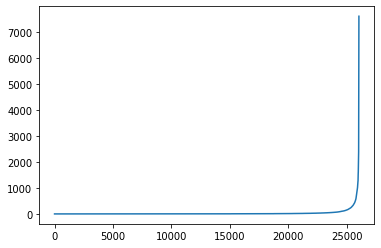

In [38]:
ref_pop = pop_info['click_count_{}'.format(7)].values #
# ref_pop = pop_info['tot_click'].values
# ref_pop = pop_info['test_click'].values # pop_info['click_count_{}'.format(0)].values#
index1  = np.argsort(ref_pop)
ref_m = ref_pop[index1].copy()
ref_m += 1
# ref_m = ref_m / ref_m.sum()
# ref_m = (ref_m-ref_m.min()) / (ref_m.max()-ref_m.min())
plt.plot(ref_m)

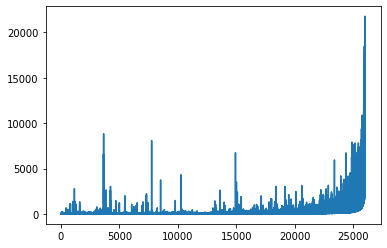

In [39]:
m = pop_info['tot_click'].values[index1]
m += 1
# m = m/m.sum()
# m = (m-m.min())/(m.max()-m.min())
plt.plot(m)

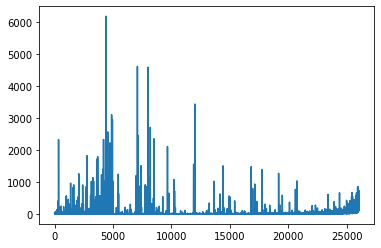

In [40]:
m = pop_info['test_click'].values[index1]
m += 1
# m = m/m.sum()
# m = (m-m.min())/(m.max()-m.min())
plt.plot(m)

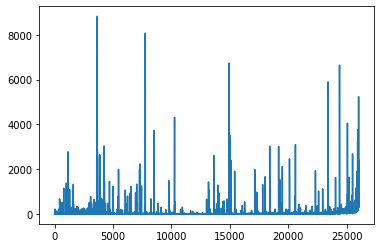

In [41]:
m8 = pop_info['click_count_{}'.format(8)].values[index1]
m8 += 1
# m = m/m.sum()
# m8 = (m-m.min())/(m.max()-m.min())
plt.plot(m8)


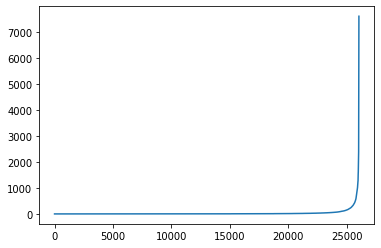

In [42]:
m7 = pop_info['click_count_{}'.format(7)].values[index1]
m7 += 1
# m = m/m.sum()
# m7 = (m-m.min())/(m.max()-m.min())
plt.plot(m7)

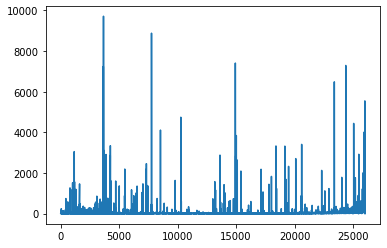

In [43]:
d = m8-m7
# index2 = np.where(m8<200)
# index3 = np.where(d>0)
# index  = np.intersect1d(index2[0],index3[0])
# d[index] *= 100
plt.plot(m8+0.1*d)

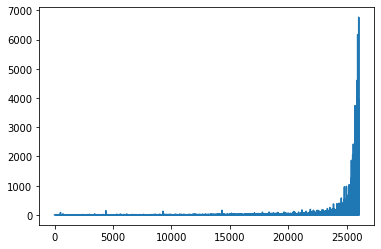

In [44]:
m = pop_info['click_count_{}'.format(6)].values[index1]
m += 1
# m = m/m.sum()
# m7 = (m-m.min())/(m.max()-m.min())
plt.plot(m)


In [45]:
s_idx =index1[8000:12000]


In [46]:
plt.plot(pop_info['click_count_{}'.format(8)].values[s_idx][idx2])


NameError: name 'idx2' is not defined

In [ ]:
plt.plot(pop_info['tot_click'].values[s_idx][idx2])

In [ ]:
plt.plot(pop_info['test_click'].values[s_idx][idx2])


In [ ]:
mm = pop_info['test_click'].values[s_idx]
idx2 = np.argsort(-mm)[0:20]


